In [2]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns
import pysam
import re

from collections import Counter, defaultdict
from pyfaidx import Fasta
from tqdm.notebook import tqdm

# Finding possible interactors of LIN28A which might cause peri-ER localization

The original article suggested strong evidences such that:
- Integral membrane protein coding mRNAs are highly enriched by LIN28A (and also, their translation highly downregulated)
- Specifically, cotranslationally ER translocated mRNAs are highly enriched by LIN28A
- LIN28A is localized to peri-ER area

But since motif score analysis done by HMM didn't show differences between ER-associated mRNAs and non-ER-associated mRNAs, we still don't know why LIN28A is localized to peri-ER area. So I will start from following hypotheses:
1. LIN28A interacts with ER surface protein/lipid
2. LIN28A interacts with RBP or adapter protein s.t. cotranslationally bounds to ER-associated mRNA.
3. LIN28A directly recognizes ER-associated mRNA sequence/structure/modification context.

Performed some pilot research, but found no evidences supporting hypothesis 1 and 2. Using other CLIP-seq or Ribosome profiling (a.k.a. Ribosome footprinting) data to find other novel recognition site of LIN28A would be better.

In [ ]:
# So let's start from here...

# New research plan: calculating codon occupancy with ribosome profiling data

1. Get P-site offset w.r.t read length
2. Calculate P-site occupancy over exons
3. Calculate and nomalize codon occupancy

In [ ]:
# Manually extract exons with start codon
!grep $'\tstart_codon\t.*\t[+-]\t.*transcript_support_level "1"' ../binfo1-datapack1/gencode.gtf | \
    sed -e 's/	[^	]*transcript_id "\([^"]*\)".*$/	\1/g' > gencode-start.gtf

In [ ]:
!grep $'\texon\t.*\t[+-]\t.*transcript_support_level "1"' ../binfo1-datapack1/gencode.gtf | \
    sed -e 's/	[^	]*transcript_id "\([^"]*\)".*$/	\1/g' > gencode-exon.gtf

In [ ]:
# Convert coordinates to 0-based, half-open
!bedtools intersect -a gencode-start.gtf -b gencode-exon.gtf -wa -wb | \
 awk -F'	' -v OFS='	' '$9 == $18 { print $10, $13-1, $14, $18, $4-1, $16; }' | \
 sort -k1,1 -k2,3n -k4,4 > gencode-exons-containing-startcodon.bed
!head gencode-exons-containing-startcodon.bed; tail gencode-exons-containing-startcodon.bed

In [ ]:
# Now remove duplicates by selecting principal transcripts
%cd ../binfo1-datapack1
!stringtie RNA-siLuc.bam -G gencode.gtf -o stringtie-RNA-siLuc.gtf -p 10
!awk -F'\t' '$3 == "transcript"' stringtie-RNA-siLuc.gtf > stringtie-RNA-siLuc-transcript.gtf

In [ ]:
!mv stringtie-RNA-siLuc-transcript.gtf ../binfo1-own-analysis/
%cd ../binfo1-own-analysis

In [40]:
# You can resume from here
# 1-based, closed coordinates
df = pd.read_csv('stringtie-RNA-siLuc-transcript.gtf', sep='\t', header=None)
df.columns = ['chromosome', 'program', 'type', 'start', 'end', 'unnamed1', 'strand', 'unnamed2', 'info']

In [ ]:
df['TPM'] = df['info'].str.extract(r'TPM "([^"]+)"').astype(float)
df['transcript_id'] = df['info'].str.extract(r'reference_id "([^"]+)"')
df.head()

,chromosome,program,type,start,end,unnamed1,strand,unnamed2,info,TPM,transcript_id
0,chr1,StringTie,transcript,3822233,3824583,1000,+,.,"gene_id ""STRG.1""; transcript_id ""STRG.1.1""; re...",0.035499,ENSMUST00000194454.2
1,chr1,StringTie,transcript,4599240,4599346,1000,+,.,"gene_id ""STRG.2""; transcript_id ""STRG.2.1""; re...",0.164673,ENSMUST00000240255.1
2,chr1,StringTie,transcript,4680694,4681629,1000,+,.,"gene_id ""STRG.3""; transcript_id ""STRG.3.1""; re...",1.015851,ENSMUST00000192738.2
3,chr1,StringTie,transcript,4758157,4759626,1000,-,.,"gene_id ""STRG.4""; transcript_id ""STRG.4.1""; re...",6.622187,ENSMUST00000182774.2
4,chr1,StringTie,transcript,4762442,4763647,1000,-,.,"gene_id ""STRG.5""; transcript_id ""STRG.5.1""; re...",0.312567,ENSMUST00000193443.2


In [ ]:
# 0-based, half-open coordinates
bed = pd.read_csv('gencode-exons-containing-startcodon.bed', sep='\t', header=None)
bed.columns = ['chromosome', 'start', 'end', 'transcript_id', 'start_codon', 'strand']
bed.head()

,chromosome,start,end,transcript_id,start_codon,strand
0,chr1,3740775,3741721,ENSMUST00000070533.5,3741569,-
1,chr1,4422425,4423060,ENSMUST00000027032.6,4423046,-
2,chr1,4563323,4563689,ENSMUST00000027035.10,4563627,-
3,chr1,4563323,4563713,ENSMUST00000116652.8,4563627,-
4,chr1,4563323,4563958,ENSMUST00000191939.2,4563627,-


In [43]:
merged_df = pd.merge(bed, df, on='transcript_id', how='left')
merged_df['TPM'] = merged_df['TPM'].fillna(0)
idx = merged_df.groupby(['chromosome_x', 'strand_x', 'start_codon'])['TPM'].idxmax()
principal_exons_df = merged_df.loc[idx]
principal_exons_df.head()

,chromosome_x,start_x,end_x,transcript_id,start_codon,strand_x,chromosome_y,program,type,start_y,end_y,unnamed1,strand_y,unnamed2,info,TPM
11,chr1,4878046,4878205,ENSMUST00000027036.11,4878137,+,chr1,StringTie,transcript,4878046.0,4916962.0,1000.0,+,.,"gene_id ""STRG.28""; transcript_id ""STRG.28.1""; ...",58.482693
13,chr1,4928037,4928199,ENSMUST00000081551.14,4928137,+,chr1,StringTie,transcript,4928037.0,4968128.0,1000.0,+,.,"gene_id ""STRG.29""; transcript_id ""STRG.29.1""; ...",128.363068
15,chr1,5154640,5154786,ENSMUST00000044369.13,5154674,+,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000000
16,chr1,5659228,5659528,ENSMUST00000027038.11,5659272,+,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000000
18,chr1,6300183,6300297,ENSMUST00000027040.13,6300227,+,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000000


In [ ]:
bedout = principal_exons_df[['chromosome_x', 'start_x', 'end_x', 'transcript_id', 'start_codon', 'strand_x']]
bedout.columns = ['chromosome', 'start', 'end', 'transcript_id', 'start_codon', 'strand']
bedout.to_csv('gencode-principal-exons-containing-startcodon.bed', sep='\t', header=False, index=False)
# 0-based, half-open coordinates

In [ ]:
# Generate new bam file with only mapped reads
!(samtools view -H ../binfo1-datapack1/RPF-siLuc.bam; samtools view -F 4 ../binfo1-datapack1/RPF-siLuc.bam | bioawk -c sam '{ if (length($seq) >= 25) print $0; }') | samtools view -b -o  RPF-siLuc-filtered.bam
!(samtools view -H ../binfo1-datapack1/RPF-siLin28a.bam; samtools view -F 4 ../binfo1-datapack1/RPF-siLin28a.bam | bioawk -c sam '{ if (length($seq) >= 25) print $0; }') | samtools view -b -o  RPF-siLin28a-filtered.bam
!samtools index RPF-siLuc-filtered.bam
!samtools index RPF-siLin28a-filtered.bam

In [ ]:
# # Get 5' ends of +/- strand reads
# !bedtools genomecov -ibam RPF-siLuc-filtered.bam -bg -5 -strand + > fivepcnt-RPF-siLuc.plus.bed
# !bedtools genomecov -ibam RPF-siLuc-filtered.bam -bg -5 -strand - > fivepcnt-RPF-siLuc.minus.bed

In [ ]:
# !bedtools genomecov -ibam RPF-siLin28a-filtered.bam -bg -5 -strand + > fivepcnt-RPF-siLin28a.plus.bed
# !bedtools genomecov -ibam RPF-siLin28a-filtered.bam -bg -5 -strand - > fivepcnt-RPF-siLin28a.minus.bed

In [ ]:
# !bedtools intersect -a fivepcnt-RPF-siLuc.plus.bed -b gencode-principal-exons-containing-startcodon.bed -wa -wb -nonamecheck > fivepcnt-RPF-siLuc.plus.txt
# !bedtools intersect -a fivepcnt-RPF-siLuc.minus.bed -b gencode-principal-exons-containing-startcodon.bed -wa -wb -nonamecheck > fivepcnt-RPF-siLuc.minus.txt

In [ ]:
# !bedtools intersect -a fivepcnt-RPF-siLin28a.plus.bed -b gencode-principal-exons-containing-startcodon.bed -wa -wb -nonamecheck > fivepcnt-RPF-siLin28a.plus.txt
# !bedtools intersect -a fivepcnt-RPF-siLin28a.minus.bed -b gencode-principal-exons-containing-startcodon.bed -wa -wb -nonamecheck > fivepcnt-RPF-siLin28a.minus.txt

In [ ]:
siluc = pysam.AlignmentFile('RPF-siLuc-filtered.bam', 'rb')
silin28a = pysam.AlignmentFile('RPF-siLin28a-filtered.bam', 'rb')

In [ ]:
siluc_len = Counter(read.query_length for read in siluc.fetch(until_eof=True))
silin28a_len = Counter(read.query_length for read in silin28a.fetch(until_eof=True))
siluc_len_df = pd.DataFrame(siluc_len.items(), columns=['length', 'count'])
silin28a_len_df = pd.DataFrame(silin28a_len.items(), columns=['length', 'count'])
siluc_len_df['proportion'] = siluc_len_df['count'] / siluc_len_df['count'].sum()
silin28a_len_df['proportion'] = silin28a_len_df['count'] / silin28a_len_df['count'].sum()
siluc_len_df['sample'] = 'siLuc'
silin28a_len_df['sample'] = 'siLin28a'
length_df = pd.concat([siluc_len_df, silin28a_len_df], ignore_index=True)
length_df.sort_values(by=['sample', 'length'], inplace=True)
length_df.to_csv('RPF_read_lengths.csv', index=False)

In [ ]:
# Preprocessing ends. Length distribution is saved in RPF_read_lengths.csv
length_df = pd.read_csv('RPF_read_lengths.csv')

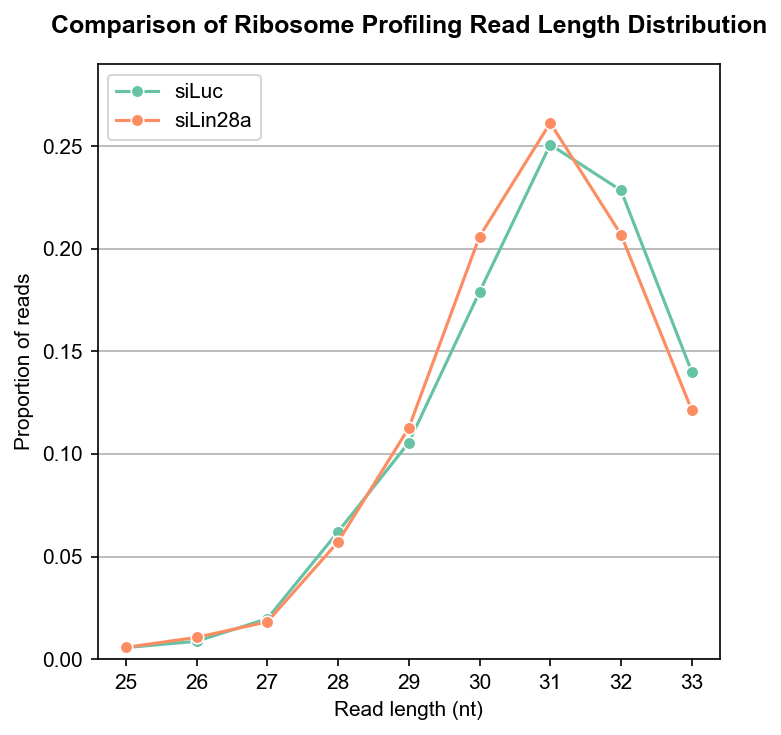

In [114]:
plt.figure(figsize=(5, 5), dpi=150)
# sns.set_style("whitegrid")
sns.lineplot(data=length_df, x='length', y='proportion', hue='sample', marker='o', palette='Set2', hue_order=['siLuc', 'siLin28a'])
plt.xlabel('Read length (nt)', fontsize=10)
plt.ylabel('Proportion of reads', fontsize=10)
plt.title('Comparison of Ribosome Profiling Read Length Distribution', fontsize=12, fontweight='bold', pad=15)
plt.ylim(0, 0.29)
plt.tight_layout()
plt.legend()
plt.grid(axis='y')
plt.show()

In [ ]:
# First, let's check the coordinate system

siluc_5p_plus = dict()
siluc_5p_minus = dict()

window = 30

for line in open('gencode-principal-exons-containing-startcodon.bed'):
    if line.startswith('#'):
        continue
    chrom, start, end, transcript_id, start_codon, strand = line.strip().split('\t')
    start_codon = int(start_codon)
    if strand == '-':
        start_codon += 2 # Points to the first base of 5' end

    for read in siluc.fetch(chrom, start_codon - window, start_codon + window):
        if read.is_unmapped or read.is_secondary or read.is_supplementary:
            continue
        if read.is_reverse != (strand == '-'):
            continue
        # pysam uses 0-based, half-open coordinates
        read_5_end = read.reference_start if strand == '+' else read.reference_end - 1
        distance = read_5_end - start_codon if strand == '+' else start_codon - read_5_end

        if distance < -window or distance >= 0:
            continue
        if strand == '+':
            if read.query_length not in siluc_5p_plus:
                siluc_5p_plus[read.query_length] = Counter()
            siluc_5p_plus[read.query_length][distance] += 1
        else:
            if read.query_length not in siluc_5p_minus:
                siluc_5p_minus[read.query_length] = Counter()
            siluc_5p_minus[read.query_length][distance] += 1

siluc_5p_plus_df = pd.DataFrame.from_dict(siluc_5p_plus, orient='index').fillna(0).astype(int)
siluc_5p_plus_df.sort_index(axis=1, inplace=True)
siluc_5p_plus_df.sort_index(axis=0, inplace=True)
siluc_5p_plus_df = siluc_5p_plus_df.loc[:, -window:0]  # Keep only distances from -30 to 0
siluc_5p_plus_df.index = siluc_5p_plus_df.index.astype(int)

siluc_5p_minus_df = pd.DataFrame.from_dict(siluc_5p_minus, orient='index').fillna(0).astype(int)
siluc_5p_minus_df.sort_index(axis=1, inplace=True)
siluc_5p_minus_df.sort_index(axis=0, inplace=True)
siluc_5p_minus_df = siluc_5p_minus_df.loc[:, -window:0]  # Keep only distances from -30 to 0
siluc_5p_minus_df.index = siluc_5p_minus_df.index.astype(int)

In [66]:
siluc_5p_plus_df = siluc_5p_plus_df.apply(lambda x: x / x.sum(), axis=1)  # Normalize each row to sum to 1
siluc_5p_minus_df = siluc_5p_minus_df.apply(lambda x: x / x.sum(), axis=1)  # Normalize each row to sum to 1

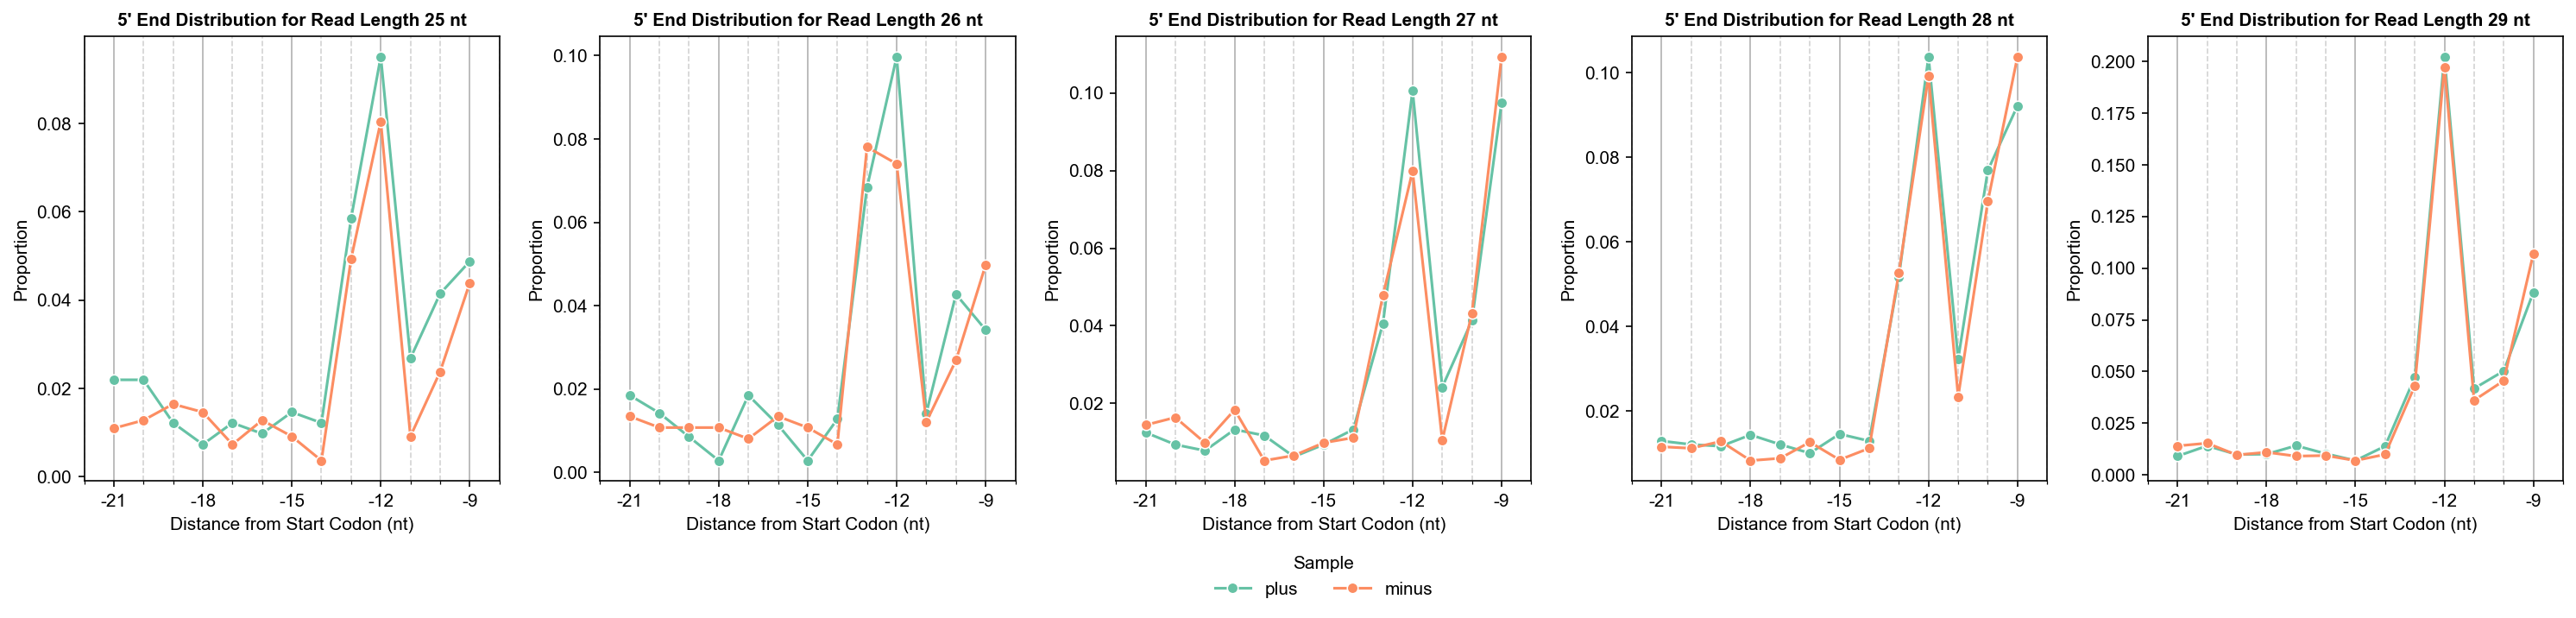

In [67]:
fig, ax = plt.subplots(nrows=1, ncols=5, figsize=(4 * 5, 5), dpi=150)
for i, length in enumerate(np.arange(25, 30)):
    row = siluc_5p_plus_df.loc[length][list(np.arange(-21, -8))]
    sns.lineplot(x=row.index, y=row.values, ax=ax[i], marker='o', color='#66c2a5', label='plus' if i == 2 else None)
    row = siluc_5p_minus_df.loc[length][list(np.arange(-21, -8))]
    sns.lineplot(x=row.index, y=row.values, ax=ax[i], marker='o', color='#fc8d62', label='minus' if i == 2 else None)

    ax[i].set_title(f'5\' End Distribution for Read Length {length} nt', fontsize=10, fontweight='bold')
    ax[i].set_xlabel('Distance from Start Codon (nt)', fontsize=10)
    ax[i].set_ylabel('Proportion', fontsize=10)
    ax[i].get_xaxis().set_major_locator(plt.MultipleLocator(3))
    ax[i].get_xaxis().set_minor_locator(plt.MultipleLocator(1))
    ax[i].grid(axis='x')
    ax[i].grid(axis='x', which='minor', color='lightgray', linestyle='--')
    ax[i].set_xlim(-22, -8)
    if i == 2:
        ax[i].legend(title='Sample', loc='lower center', bbox_to_anchor=(0.5, -0.3), ncol=2, frameon=False)

plt.tight_layout()
plt.show()

In [68]:
# Now merge the two strands for siLuc

siluc_5p = dict()

window = 30

for line in open('gencode-principal-exons-containing-startcodon.bed'):
    if line.startswith('#'):
        continue
    chrom, start, end, transcript_id, start_codon, strand = line.strip().split('\t')
    start_codon = int(start_codon)
    if strand == '-':
        start_codon += 2

    for read in siluc.fetch(chrom, start_codon - window, start_codon + window):
        if read.is_unmapped or read.is_secondary or read.is_supplementary:
            continue
        if read.is_reverse != (strand == '-'):
            continue

        read_5_end = read.reference_start if strand == '+' else read.reference_end - 1
        distance = read_5_end - start_codon if strand == '+' else start_codon - read_5_end

        if distance < -window or distance >= 0:
            continue

        if read.query_length not in siluc_5p:
            siluc_5p[read.query_length] = Counter()
        siluc_5p[read.query_length][distance] += 1

siluc_5p_df = pd.DataFrame.from_dict(siluc_5p, orient='index').fillna(0).astype(int)
siluc_5p_df.sort_index(axis=1, inplace=True)
siluc_5p_df.sort_index(axis=0, inplace=True)
siluc_5p_df = siluc_5p_df.loc[:, -window:0]  # Keep only distances from -30 to 0
siluc_5p_df.index = siluc_5p_df.index.astype(int)
siluc_5p_df.head()

,-30,-29,-28,-27,-26,-25,-24,-23,-22,-21,...,-10,-9,-8,-7,-6,-5,-4,-3,-2,-1
25,9,6,9,10,13,11,8,2,12,15,...,30,44,24,84,98,53,98,63,34,105
26,24,22,13,17,27,6,3,13,25,23,...,50,61,107,140,116,66,108,93,63,115
27,31,29,26,37,18,16,25,32,29,38,...,119,292,204,215,244,112,169,204,133,204
28,102,137,136,64,47,104,118,115,111,127,...,756,1018,469,631,856,284,765,693,335,779
29,327,352,134,91,296,245,293,372,333,317,...,1290,2655,732,1002,2336,593,1260,2965,569,1158


In [69]:
siluc_5p_df = siluc_5p_df.apply(lambda x: x / x.sum(), axis=1)  # Normalize each row to sum to 1
siluc_5p_df.head()

,-30,-29,-28,-27,-26,-25,-24,-23,-22,-21,...,-10,-9,-8,-7,-6,-5,-4,-3,-2,-1
25,0.009404,0.006270,0.009404,0.010449,0.013584,0.011494,0.008359,0.002090,0.012539,0.015674,...,0.031348,0.045977,0.025078,0.087774,0.102403,0.055381,0.102403,0.065831,0.035528,0.109718
26,0.016609,0.015225,0.008997,0.011765,0.018685,0.004152,0.002076,0.008997,0.017301,0.015917,...,0.034602,0.042215,0.074048,0.096886,0.080277,0.045675,0.074740,0.064360,0.043599,0.079585
27,0.011036,0.010324,0.009256,0.013172,0.006408,0.005696,0.008900,0.011392,0.010324,0.013528,...,0.042364,0.103952,0.072624,0.076540,0.086864,0.039872,0.060164,0.072624,0.047348,0.072624
28,0.009847,0.013226,0.013130,0.006179,0.004538,0.010041,0.011392,0.011103,0.010716,0.012261,...,0.072987,0.098282,0.045279,0.060919,0.082641,0.027418,0.073856,0.066905,0.032342,0.075208
29,0.012110,0.013036,0.004963,0.003370,0.010962,0.009073,0.010851,0.013777,0.012332,0.011740,...,0.047774,0.098326,0.027109,0.037108,0.086512,0.021961,0.046663,0.109807,0.021073,0.042886


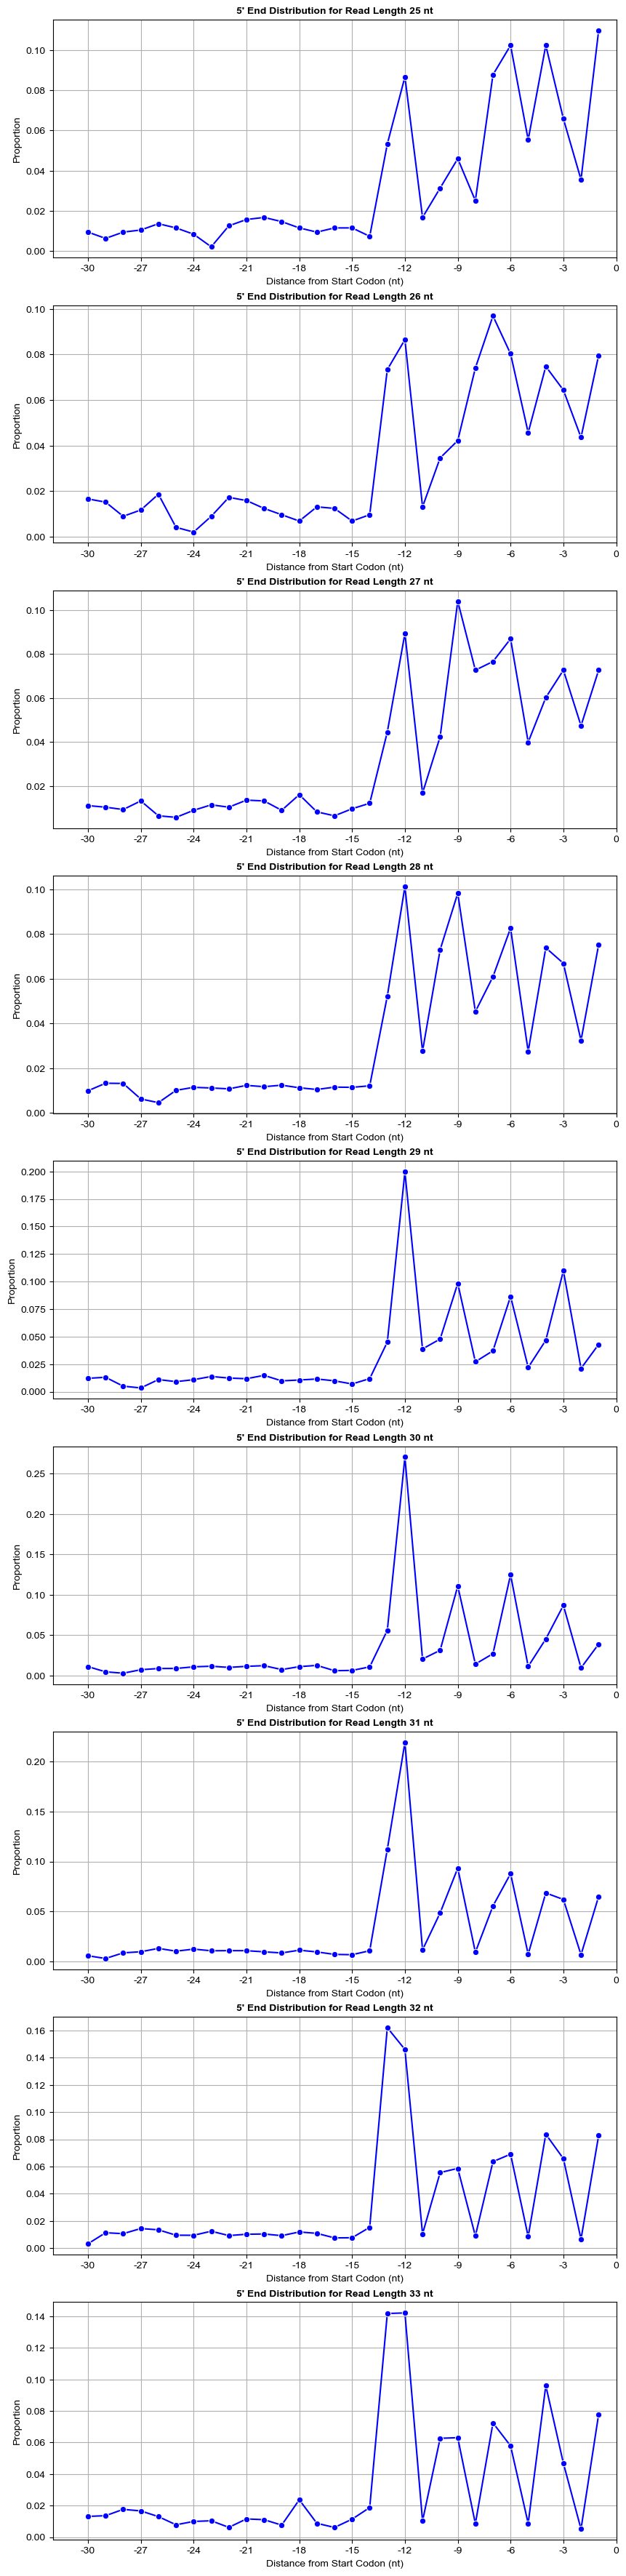

In [70]:
temp = siluc_5p_df.loc[25:33, -window:0].copy()
fig, ax = plt.subplots(nrows=temp.shape[0], ncols=1, figsize=(10, 5 * temp.shape[0]))
for i, (length, row) in enumerate(temp.iterrows()):
    sns.lineplot(x=row.index, y=row.values, ax=ax[i], marker='o', color='blue')
    ax[i].set_title(f'5\' End Distribution for Read Length {length} nt', fontsize=10, fontweight='bold')
    ax[i].set_xlabel('Distance from Start Codon (nt)', fontsize=10)
    ax[i].set_ylabel('Proportion', fontsize=10)
    ax[i].grid(True)
    ax[i].get_xaxis().set_major_locator(plt.MultipleLocator(3))
    ax[i].set_xlim(-window-2, 0)

In [71]:
# Now merge with siLin28a

silin28a_5p = dict()

window = 30

for line in open('gencode-principal-exons-containing-startcodon.bed'):
    if line.startswith('#'):
        continue
    chrom, start, end, transcript_id, start_codon, strand = line.strip().split('\t')
    start_codon = int(start_codon)
    if strand == '-':
        start_codon += 2

    for read in silin28a.fetch(chrom, start_codon - window, start_codon + window):
        if read.is_unmapped or read.is_secondary or read.is_supplementary:
            continue
        if read.is_reverse != (strand == '-'):
            continue
        read_5_end = read.reference_start if strand == '+' else read.reference_end - 1
        distance = read_5_end - start_codon if strand == '+' else start_codon - read_5_end

        if distance < -window or distance >= 0:
            continue

        if read.query_length not in silin28a_5p:
            silin28a_5p[read.query_length] = Counter()
        silin28a_5p[read.query_length][distance] += 1

silin28a_5p_df = pd.DataFrame.from_dict(silin28a_5p, orient='index').fillna(0).astype(int)
silin28a_5p_df.sort_index(axis=1, inplace=True)
silin28a_5p_df.sort_index(axis=0, inplace=True)
silin28a_5p_df = silin28a_5p_df.loc[:, -window:window]  # Keep only distances from -30 to 0
silin28a_5p_df.index = silin28a_5p_df.index.astype(int)
silin28a_5p_df = silin28a_5p_df.apply(lambda x: x / x.sum(), axis=1)  # Normalize each row to sum to 1
silin28a_5p_df.head()

,-30,-29,-28,-27,-26,-25,-24,-23,-22,-21,...,-10,-9,-8,-7,-6,-5,-4,-3,-2,-1
25,0.001285,0.008997,0.003856,0.007712,0.003856,0.017995,0.003856,0.002571,0.007712,0.011568,...,0.025707,0.052699,0.035990,0.120823,0.107969,0.095116,0.104113,0.068123,0.032134,0.073265
26,0.009223,0.004611,0.005929,0.009881,0.008564,0.007905,0.001976,0.009223,0.010540,0.013175,...,0.032279,0.065217,0.074440,0.113307,0.093544,0.042161,0.068511,0.060606,0.051383,0.055336
27,0.006930,0.006523,0.011822,0.008969,0.005300,0.004484,0.005707,0.011822,0.007746,0.008969,...,0.046881,0.119038,0.081940,0.064819,0.087240,0.034244,0.050958,0.073380,0.032613,0.059111
28,0.007539,0.010406,0.010512,0.005097,0.005521,0.006795,0.007963,0.010193,0.007645,0.008070,...,0.086324,0.118072,0.043003,0.051391,0.093332,0.021130,0.058930,0.059461,0.021342,0.049904
29,0.008590,0.010187,0.003768,0.003257,0.007089,0.007600,0.009133,0.011049,0.009389,0.009133,...,0.040557,0.105193,0.021843,0.026410,0.086766,0.018043,0.031551,0.105480,0.013955,0.027528


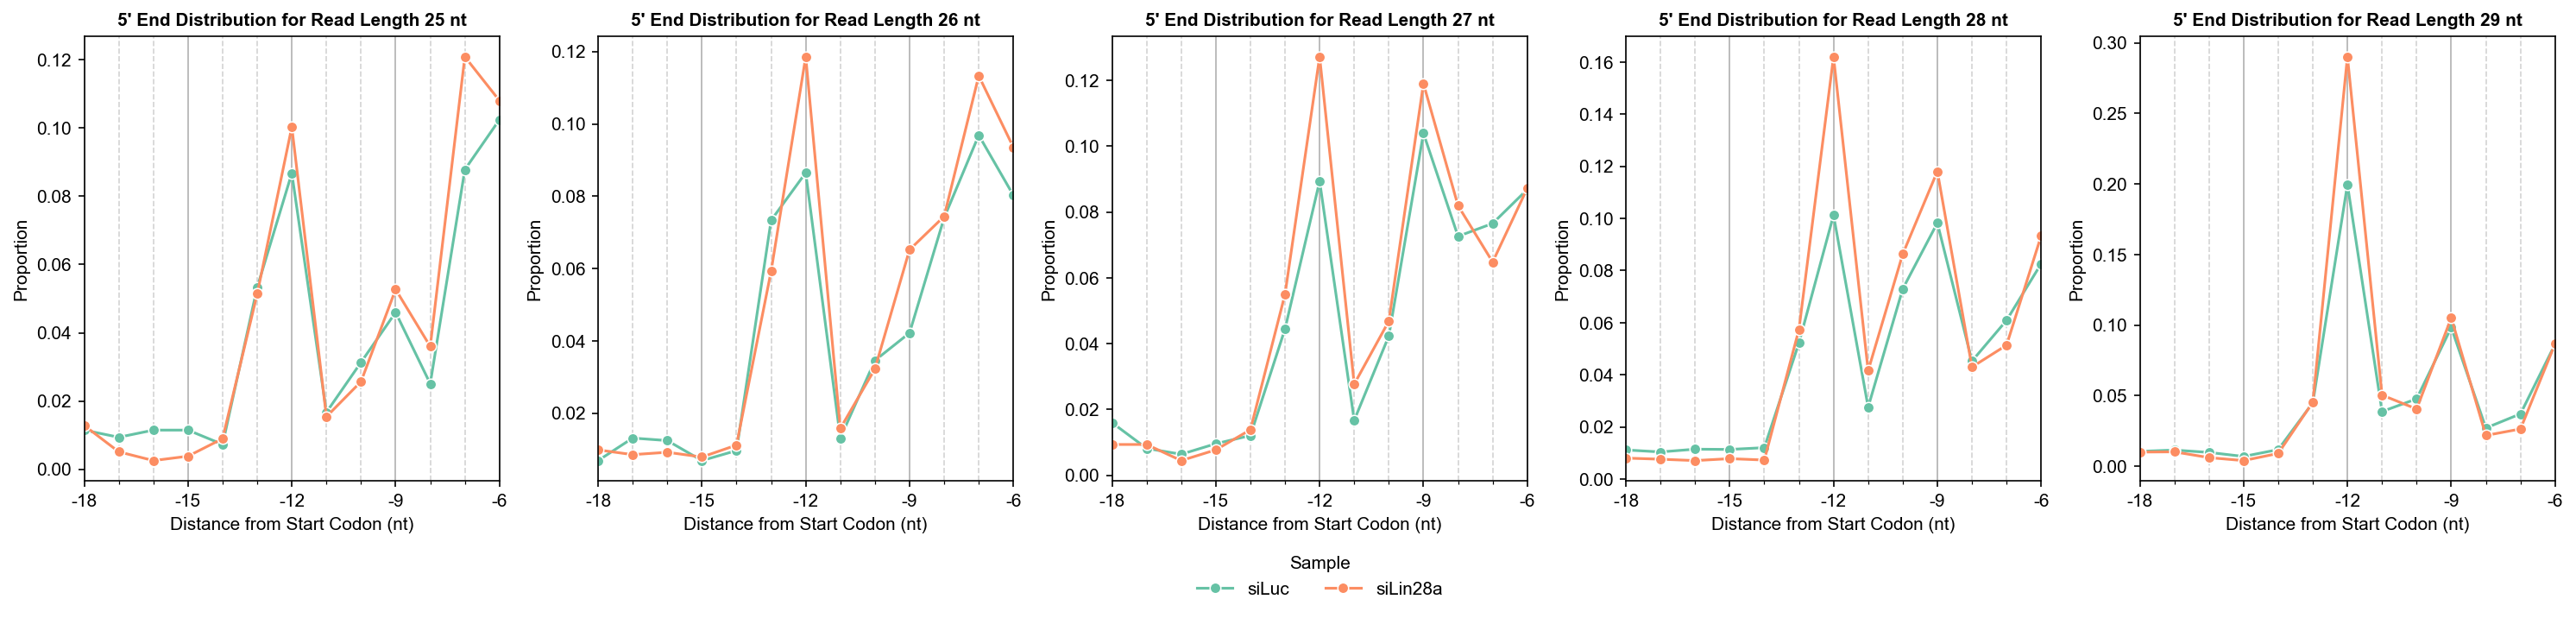

In [91]:
fig, ax = plt.subplots(nrows=1, ncols=5, figsize=(4 * 5, 5), dpi=150)
for i, length in enumerate(np.arange(25, 30)):
    row = siluc_5p_df.loc[length][list(np.arange(-18, -5))]
    sns.lineplot(x=row.index, y=row.values, ax=ax[i], marker='o', color='#66c2a5', label='siLuc' if i == 2 else None)
    row = silin28a_5p_df.loc[length][list(np.arange(-18, -5))]
    sns.lineplot(x=row.index, y=row.values, ax=ax[i], marker='o', color='#fc8d62', label='siLin28a' if i == 2 else None)

    ax[i].set_title(f'5\' End Distribution for Read Length {length} nt', fontsize=10, fontweight='bold')
    ax[i].set_xlabel('Distance from Start Codon (nt)', fontsize=10)
    ax[i].set_ylabel('Proportion', fontsize=10)
    ax[i].get_xaxis().set_major_locator(plt.MultipleLocator(3))
    ax[i].get_xaxis().set_minor_locator(plt.MultipleLocator(1))
    ax[i].grid(axis='x')
    ax[i].grid(axis='x', which='minor', color='lightgray', linestyle='--')
    ax[i].set_xlim(-18, -6)
    if i == 2:
        ax[i].legend(title='Sample', loc='lower center', bbox_to_anchor=(0.5, -0.3), ncol=2, frameon=False)

plt.tight_layout()
plt.show()

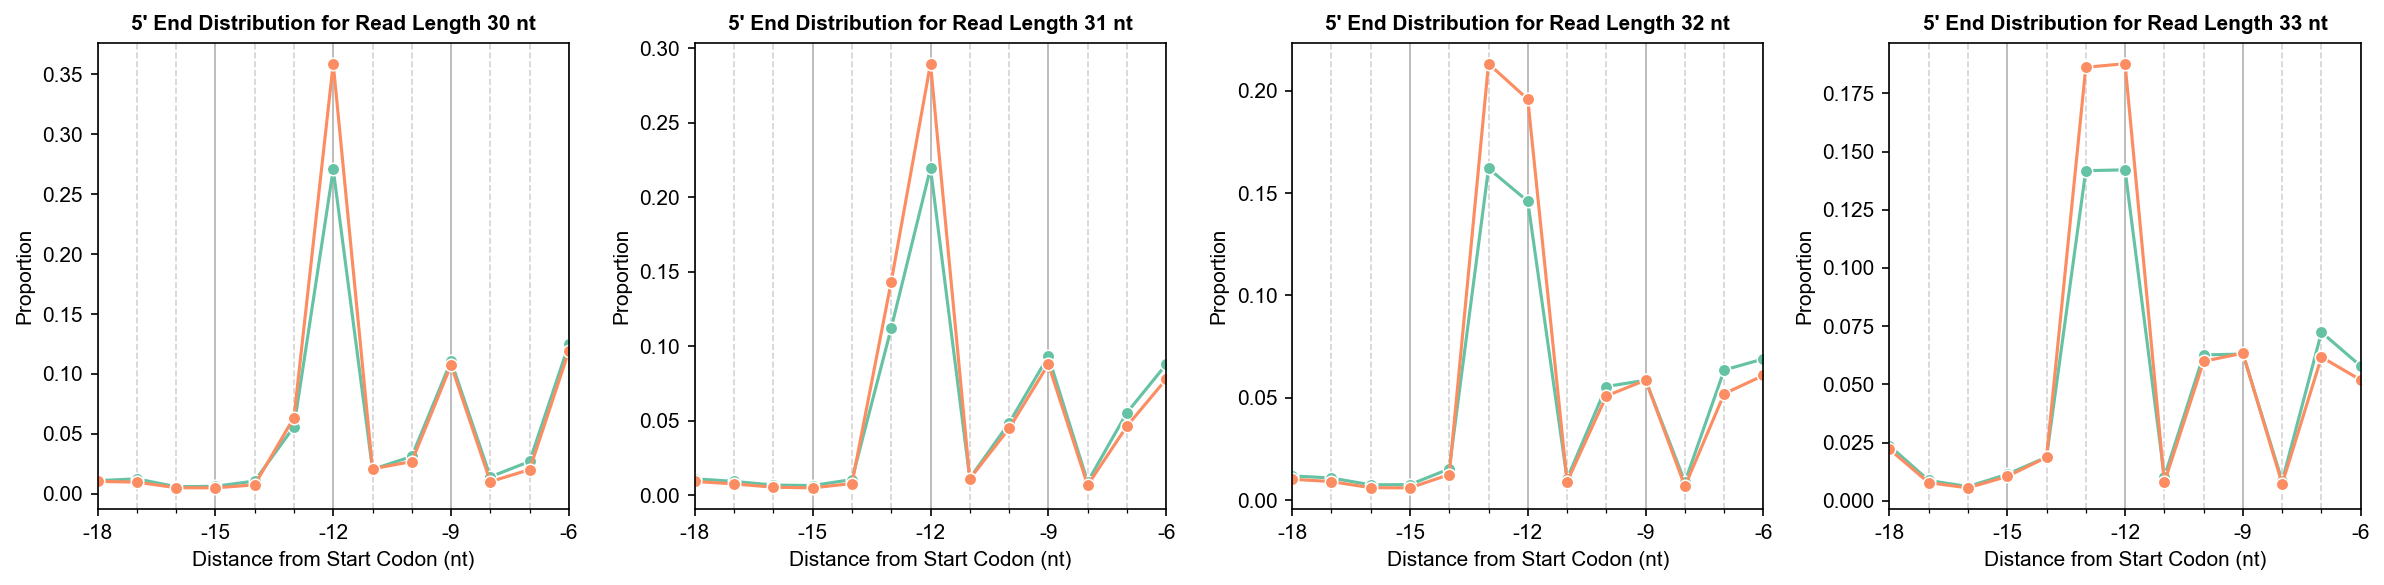

In [96]:
fig, ax = plt.subplots(nrows=1, ncols=4, figsize=(4 * 4, 4), dpi=150)
for i, length in enumerate(np.arange(30, 34)):
    row = siluc_5p_df.loc[length][list(np.arange(-18, -5))]
    sns.lineplot(x=row.index, y=row.values, ax=ax[i], marker='o', color='#66c2a5')
    row = silin28a_5p_df.loc[length][list(np.arange(-18, -5))]
    sns.lineplot(x=row.index, y=row.values, ax=ax[i], marker='o', color='#fc8d62')

    ax[i].set_title(f'5\' End Distribution for Read Length {length} nt', fontsize=10, fontweight='bold')
    ax[i].set_xlabel('Distance from Start Codon (nt)', fontsize=10)
    ax[i].set_ylabel('Proportion', fontsize=10)
    ax[i].get_xaxis().set_major_locator(plt.MultipleLocator(3))
    ax[i].get_xaxis().set_minor_locator(plt.MultipleLocator(1))
    ax[i].grid(axis='x')
    ax[i].grid(axis='x', which='minor', color='lightgray', linestyle='--')
    ax[i].set_xlim(-18, -6)


plt.tight_layout()
plt.show()

In [56]:
# P-site offsets of mESCs from (Ingolia et al., 2011)

# poffset = {
#     29: 12,
#     30: 12,
#     31: 13,
#     32: 13,
#     33: 13,
#     34: 14,
#     35: 14
# }

# My offsets. Exclude reads shorter than 27 nt, and longer than 33 nt.

poffset = {
    27: 12,
    28: 12,
    29: 12,
    30: 12,
    31: 12,
    32: 13,
    33: 13,
}

In [57]:
# Maybe I can double-check offsets with A-site offsets from stop codon, but I will leave that for later

!(samtools view -H RPF-siLuc-filtered.bam; samtools view RPF-siLuc-filtered.bam | bioawk -c sam '{ if (length($seq) >= 27 && length($seq) <= 31) print $0; }') | samtools view -b -o  RPF-siLuc-filtered-27-31.bam
!(samtools view -H RPF-siLin28a-filtered.bam; samtools view RPF-siLin28a-filtered.bam | bioawk -c sam '{ if (length($seq) >= 27 && length($seq) <= 31) print $0; }') | samtools view -b -o  RPF-siLin28a-filtered-27-31.bam
!samtools index RPF-siLuc-filtered-27-31.bam
!samtools index RPF-siLin28a-filtered-27-31.bam

In [30]:
!grep $'\tCDS\t.*\t[+-]\t.*transcript_support_level "1"' ../binfo1-datapack1/gencode.gtf | sed -e 's/\t[^\t]*gene_id "\([^"]*\)".*transcript_id "\([^"]*\)".*$/\t\2\t\1/' > gencode-cds-with-genename.gtf

In [60]:
# -------------------------------- #
# -- Codes generated by Gemini --- #
# -------------------------------- #

# 2. 분석할 BAM 파일 경로
BAM_FILES = {
    'siLuc': 'RPF-siLuc-filtered-27-31.bam',
    'siLin28a': 'RPF-siLin28a-filtered-27-31.bam'
}

In [ ]:
# 3. 주석(Annotation) 및 레퍼런스 유전체 파일 경로
GTF_FILE = 'gencode-cds-with-genename.gtf'

# pandas로 GTF 파일 읽기
gtf_df = pd.read_csv(
    GTF_FILE, sep='\t', comment='#', header=None,
    names=['chrom', 'source', 'feature', 'start', 'end', 'score', 'strand', 'frame', 'transcript_id', 'gene_id']
)

# 전사체(transcript)를 기준으로 엑손 정보 그룹화
transcripts = {}
for transcript_id, group in tqdm(gtf_df.groupby('transcript_id'), desc="Processing Transcripts"):
    # 엑손들을 시작 위치 기준으로 정렬
    group = group.sort_values('start')

    transcripts[transcript_id] = {
        'gene_id': group['gene_id'].iloc[0],
        'chrom': group['chrom'].iloc[0],
        'strand': group['strand'].iloc[0],
        'exons': list(zip(group['start'], group['end']))
    }

print(f"총 {len(transcripts)}개의 전사체 정보 로드 완료.")

In [ ]:
def get_codon_counts_v2(bam_path, transcripts_info, genome_fasta, offset_map):
    """
    [V2] ORF를 정확히 고려하여 유전자별 P-site 코돈 카운트를 계산하는 함수
    """
    bamfile = pysam.AlignmentFile(bam_path, "rb")
    # 결과 저장 구조: {gene_id: {codon: count}}
    gene_codon_counts = defaultdict(lambda: defaultdict(int))
    # 프레임 벗어난 리드 카운트
    out_of_frame_counts = defaultdict(int)
    wrong_cds = 0
    frame_df = pd.DataFrame(index=np.arange(27, 34), columns=['plus_0', 'plus_1', 'plus_2', 'minus_0', 'minus_1', 'minus_2']).fillna(0)
    cnt = 0

    for transcript_id, t_info in tqdm(transcripts_info.items(), desc=f"Processing {bam_path}"):
        cnt += 1
        if cnt == 1000:
            break
        # 1. 'CDS' 구간들로 실제 CDS 서열을 구성
        cds_seq = ""
        # t_info['exons']는 이제 CDS 구간들의 리스트임
        cds_segments = sorted(t_info['exons'], key=lambda x: x[0]) # 유전체 좌표 기준 정렬

        for cds_start, cds_end in cds_segments:
            cds_seq += genome_fasta[t_info['chrom']][cds_start - 1:cds_end].seq #  # 1-based, half-open 좌표이므로 cds_start - 1

        if t_info['strand'] == '-':
            tr_table = str.maketrans('ATCG', 'TAGC')
            cds_seq = cds_seq.upper().translate(tr_table)[::-1]

        # CDS 서열의 시작이 AUG가 아니거나 길이가 3의 배수가 아니면 건너뛰기 (품질 관리)
        if not cds_seq.startswith('ATG') or len(cds_seq) % 3 != 0:
            wrong_cds += 1
            continue

        # 2. 해당 전사체 영역의 리드들을 순회
        # 1-based coordinate
        t_start = min(s for s, e in cds_segments)
        t_end = max(e for s, e in cds_segments)

        for read in bamfile.fetch(t_info['chrom'], t_start - 1, t_end):
            read_strand = '-' if read.is_reverse else '+'
            if read_strand != t_info['strand']:
                continue

            read_len = read.query_length
            if read_len not in offset_map:
                continue

            offset = offset_map[read_len]

            # 3. P-site의 '유전체' 좌표 계산
            # read.reference_start는 0-based, half-open 좌표임에 주의
            p_site_genomic = (read.reference_start + offset) if read_strand == '+' else (read.reference_end - 1 - offset)

            # 4. 유전체 좌표 -> 'CDS' 기준 상대 좌표로 변환
            p_site_cds = -1
            len_so_far = 0

            # cds_start와 cds_end는 1-based
            for cds_start, cds_end in cds_segments:
                if p_site_genomic >= cds_start - 1 and p_site_genomic < cds_end:
                    if t_info['strand'] == '+':
                        p_site_cds = len_so_far + (p_site_genomic - (cds_start - 1))
                    else:
                        p_site_cds = len_so_far + (cds_end - 1 - p_site_genomic)
                    break
                len_so_far += (cds_end - cds_start + 1)

            if p_site_cds == -1:
                continue

            # 5. 프레임 확인 및 코돈 카운트
            # P-site는 코돈의 첫번째 염기이므로, 0-based 좌표는 3의 배수여야 함
            if read_strand == '+':
                frame_df.loc[read_len, f'plus_{p_site_cds % 3}'] += 1
            elif read_strand == '-':
                frame_df.loc[read_len, f'minus_{p_site_cds % 3}'] += 1

            if p_site_cds % 3 == 0:
                if p_site_cds + 3 <= len(cds_seq):
                    codon = cds_seq[p_site_cds : p_site_cds + 3]
                    if 'N' not in codon:
                        gene_codon_counts[t_info['gene_id']][codon] += 1
            else:
                # 3의 배수가 아닌 경우 (out-of-frame)
                out_of_frame_counts[t_info['gene_id']] += 1

    bamfile.close()

    print(f"Total out-of-frame reads found: {sum(out_of_frame_counts.values())}, wrong CDS: {wrong_cds}")
    print(f"Frame distribution:\n{frame_df}")
    result_df = pd.DataFrame.from_dict(gene_codon_counts, orient='index').fillna(0).astype(int)
    return result_df


In [ ]:
# get_codon_counts_v2 함수를 아래 v3 버전으로 교체하여 사용하시면 됩니다.

def get_codon_counts_v3(bam_path, transcripts_info, genome_fasta, offset_map):
    """
    [V3] Minus strand 좌표 계산 로직을 더 명확하게 수정한 버전
    """
    bamfile = pysam.AlignmentFile(bam_path, "rb")
    gene_codon_counts = defaultdict(lambda: defaultdict(int))
    out_of_frame_counts = defaultdict(int)
    # frame_df = pd.DataFrame(index=np.arange(27, 34), columns=['plus_0', 'plus_1', 'plus_2', 'minus_0', 'minus_1', 'minus_2']).fillna(0)
    # cnt = 0

    for transcript_id, t_info in tqdm(transcripts_info.items(), desc=f"Processing {bam_path}"):
        # cnt += 1
        # if cnt == 1000:
            # break

        # --- CDS 서열 구성 (이전과 동일) ---
        cds_seq = ""
        cds_segments = sorted(t_info['exons'], key=lambda x: x[0])
        for cds_start, cds_end in cds_segments:
            cds_seq += genome_fasta[t_info['chrom']][cds_start - 1:cds_end].seq
        if t_info['strand'] == '-':
            tr_table = str.maketrans('ATCG', 'TAGC')
            cds_seq = cds_seq.upper().translate(tr_table)[::-1]
        if not cds_seq.startswith('ATG') or len(cds_seq) % 3 != 0:
            continue

        # --- 리드 순회 및 P-site 계산 (로직 수정) ---
        t_start = min(s for s, e in cds_segments)
        t_end = max(e for s, e in cds_segments)

        for read in bamfile.fetch(t_info['chrom'], t_start - 1, t_end):
            read_strand = '-' if read.is_reverse else '+'
            if read_strand != t_info['strand']:
                continue

            read_len = read.query_length
            if read_len not in offset_map:
                continue

            offset = offset_map[read_len]

            if read_strand == '+':
                p_site_genomic = read.reference_start + offset

                # Plus strand: 유전체 순서(오름차순)로 엑손 순회
                len_so_far = 0
                p_site_cds = -1
                for cds_start, cds_end in cds_segments:
                    if p_site_genomic >= cds_start - 1 and p_site_genomic < cds_end:
                        p_site_cds = len_so_far + (p_site_genomic - (cds_start - 1))
                        break
                    len_so_far += (cds_end - cds_start + 1)

            else: # '-' strand
                p_site_genomic = read.reference_end - 1 - offset

                # [수정된 핵심 로직]
                # Minus strand: 생물학적 순서(유전체 내림차순)로 엑손 순회
                len_so_far = 0
                p_site_cds = -1
                for cds_start, cds_end in reversed(cds_segments): # reversed() 사용
                    if p_site_genomic >= cds_start - 1 and p_site_genomic < cds_end:
                        # 현재 엑손 내에서의 상대적 위치 (엑손의 3' 말단(생물학적 5') 기준)
                        pos_in_exon = (cds_end - 1) - p_site_genomic
                        p_site_cds = len_so_far + pos_in_exon
                        break
                    len_so_far += (cds_end - cds_start + 1)

            if p_site_cds == -1:
                continue

            # if read_strand == '+':
            #     frame_df.loc[read_len, f'plus_{p_site_cds % 3}'] += 1
            # elif read_strand == '-':
            #     frame_df.loc[read_len, f'minus_{p_site_cds % 3}'] += 1

            # --- 프레임 확인 및 코돈 카운트 (이전과 동일) ---
            if p_site_cds % 3 == 0:
                if p_site_cds + 3 <= len(cds_seq):
                    codon = cds_seq[p_site_cds : p_site_cds + 3]
                    if 'N' not in codon:
                        gene_codon_counts[t_info['gene_id']][codon] += 1
            else:
                out_of_frame_counts[t_info['gene_id']] += 1

    bamfile.close()

    print(f"Total out-of-frame reads found: {sum(out_of_frame_counts.values())}")
    # print(f"Frame distribution:\n{frame_df}")
    result_df = pd.DataFrame.from_dict(gene_codon_counts, orient='index').fillna(0).astype(int)
    return result_df

In [71]:
# 레퍼런스 유전체 파일 열기
FASTA_FILE = '../binfo1-datapack1/mm39.fa'
genome = Fasta(FASTA_FILE, sequence_always_upper=True)

# 각 샘플에 대해 코돈 카운트 계산
results = {}
for name, bam_file in BAM_FILES.items():
    print(f"\n--- {name} 샘플 분석 시작 ---")
    results[name] = get_codon_counts_v3(bam_file, transcripts, genome, poffset)

genome.close()

print("\n--- 분석 완료 ---")

# siLuc 샘플 결과 확인
print("\nsiLuc 샘플 결과 (상위 5개 유전자):")
display(results['siLuc'].head())

# siLin28a 샘플 결과 확인
print("\nsiLin28a 샘플 결과 (상위 5개 유전자):")
display(results['siLin28a'].head())


--- siLuc 샘플 분석 시작 ---


Processing RPF-siLuc-filtered-27-31.bam:   0%|          | 0/30846 [00:00<?, ?it/s]

Total out-of-frame reads found: 2695177

--- siLin28a 샘플 분석 시작 ---


Processing RPF-siLin28a-filtered-27-31.bam:   0%|          | 0/30846 [00:00<?, ?it/s]

Total out-of-frame reads found: 2103613

--- 분석 완료 ---

siLuc 샘플 결과 (상위 5개 유전자):


,CTT,AAC,GTC,GTT,GAT,GAC,ACA,GCC,TTC,GAG,...,GGT,CCC,CGT,TTG,AAT,ACG,CTA,GTA,ATA,TGA
ENSMUSG00000000001.5,1,2,2,7,20,15,5,3,1,3,...,0,0,0,0,0,0,0,0,0,0
ENSMUSG00000000088.8,7,2,1,65,142,3,5,32,6,58,...,0,26,18,16,7,0,0,0,0,0
ENSMUSG00000020152.8,17,46,17,59,122,206,24,3,12,102,...,51,20,12,17,35,0,2,12,5,0
ENSMUSG00000000184.13,3,14,0,5,4,13,2,4,0,13,...,0,1,0,2,0,0,0,3,0,0
ENSMUSG00000000275.17,2,10,20,0,60,56,4,22,10,48,...,0,6,26,10,10,4,4,18,2,0



siLin28a 샘플 결과 (상위 5개 유전자):


,AAA,ACG,ACA,ACC,ACT,AAC,CTG,GAT,GCT,TAT,...,GCG,TCG,ATT,CAC,ATC,CGA,AAT,GGT,CCG,TGA
ENSMUSG00000000001.5,1,3,3,3,1,1,2,9,2,2,...,0,0,0,0,0,0,0,0,0,0
ENSMUSG00000000078.8,1,0,0,2,0,0,1,0,1,1,...,0,0,0,0,0,0,0,0,0,0
ENSMUSG00000000088.8,13,0,13,2,55,2,9,188,72,91,...,9,1,12,1,32,4,19,0,0,0
ENSMUSG00000000120.7,6,16,24,34,13,12,24,6,24,0,...,2,0,9,11,3,11,3,9,5,0
ENSMUSG00000020152.8,42,0,20,25,28,27,22,91,5,20,...,0,20,35,15,18,46,36,47,0,0


In [ ]:
results['siLuc'].sum(axis=1).sum(), results['siLin28a'].sum(axis=1).sum() # ~60% of reads are in-frame

(np.int64(4327503), np.int64(3913275))

In [73]:
results['siLuc'].index.name = 'gene_id'
results['siLin28a'].index.name = 'gene_id'
results['siLuc'].to_csv('siLuc_codon_counts.csv')
results['siLin28a'].to_csv('siLin28a_codon_counts.csv')

# ------------------------------------ #
# --- End of Gemini generated code --- #
# ------------------------------------ #

In [222]:
# Checkpoint 2
siluc_codon_cnt = pd.read_csv('siLuc_codon_counts.csv', index_col=0)
silin28a_codon_cnt = pd.read_csv('siLin28a_codon_counts.csv', index_col=0)
siluc_codon_cnt.head(), silin28a_codon_cnt.head()

(                       CTT  AAC  GTC  GTT  GAT  GAC  ACA  GCC  TTC  GAG  ...  \
 gene_id                                                                  ...   
 ENSMUSG00000000001.5     1    2    2    7   20   15    5    3    1    3  ...   
 ENSMUSG00000000088.8     7    2    1   65  142    3    5   32    6   58  ...   
 ENSMUSG00000020152.8    17   46   17   59  122  206   24    3   12  102  ...   
 ENSMUSG00000000184.13    3   14    0    5    4   13    2    4    0   13  ...   
 ENSMUSG00000000275.17    2   10   20    0   60   56    4   22   10   48  ...   
 
                        GGT  CCC  CGT  TTG  AAT  ACG  CTA  GTA  ATA  TGA  
 gene_id                                                                  
 ENSMUSG00000000001.5     0    0    0    0    0    0    0    0    0    0  
 ENSMUSG00000000088.8     0   26   18   16    7    0    0    0    0    0  
 ENSMUSG00000020152.8    51   20   12   17   35    0    2   12    5    0  
 ENSMUSG00000000184.13    0    1    0    2    0    0    

In [223]:
print(f"{len(siluc_codon_cnt[siluc_codon_cnt.sum(axis=1) == 0])} {len(silin28a_codon_cnt[silin28a_codon_cnt.sum(axis=1) == 0])} genes with no codon counts")

0 0 genes with no codon counts


In [224]:
siluc_codon_cnt = siluc_codon_cnt.drop(columns=['TGA'], errors='ignore')
silin28a_codon_cnt = silin28a_codon_cnt.drop(columns=['TGA'], errors='ignore')

In [225]:
siluc_codon_sum = siluc_codon_cnt.sum(axis=1)
silin28a_codon_sum = silin28a_codon_cnt.sum(axis=1)

In [226]:
siluc_codon_sum.name = 'siLuc_codon_sum'
silin28a_codon_sum.name = 'siLin28a_codon_sum'

In [227]:
siluc_codon_cnt = siluc_codon_cnt.loc[siluc_codon_sum[siluc_codon_sum.values >= 50].index].apply(lambda x: x / x.sum(), axis=1)
silin28a_codon_cnt = silin28a_codon_cnt.loc[silin28a_codon_sum[silin28a_codon_sum.values >= 50].index].apply(lambda x: x / x.sum(), axis=1)
siluc_codon_cnt.head()

,CTT,AAC,GTC,GTT,GAT,GAC,ACA,GCC,TTC,GAG,...,TCG,GGT,CCC,CGT,TTG,AAT,ACG,CTA,GTA,ATA
gene_id,,,,,,,,,,,,,,,,,,,,,
ENSMUSG00000000001.5,0.005682,0.011364,0.011364,0.039773,0.113636,0.085227,0.028409,0.017045,0.005682,0.017045,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
ENSMUSG00000000088.8,0.006239,0.001783,0.000891,0.057932,0.126560,0.002674,0.004456,0.028520,0.005348,0.051693,...,0.000891,0.000000,0.023173,0.016043,0.014260,0.006239,0.000000,0.000000,0.000000,0.000000
ENSMUSG00000020152.8,0.008608,0.023291,0.008608,0.029873,0.061772,0.104304,0.012152,0.001519,0.006076,0.051646,...,0.008101,0.025823,0.010127,0.006076,0.008608,0.017722,0.000000,0.001013,0.006076,0.002532
ENSMUSG00000000184.13,0.014423,0.067308,0.000000,0.024038,0.019231,0.062500,0.009615,0.019231,0.000000,0.062500,...,0.000000,0.000000,0.004808,0.000000,0.009615,0.000000,0.000000,0.000000,0.014423,0.000000
ENSMUSG00000000275.17,0.002191,0.010953,0.021906,0.000000,0.065717,0.061336,0.004381,0.024096,0.010953,0.052574,...,0.004381,0.000000,0.006572,0.028478,0.010953,0.010953,0.004381,0.004381,0.019715,0.002191


In [233]:
eps = 1e-20
codon_fc = np.log2((silin28a_codon_cnt + eps) / (siluc_codon_cnt + eps)).fillna(0)

In [234]:
codon_fc

,AAA,AAC,AAG,AAT,ACA,ACC,ACG,ACT,AGA,AGC,...,TCC,TCG,TCT,TGC,TGG,TGT,TTA,TTC,TTG,TTT
gene_id,,,,,,,,,,,,,,,,,,,,,
ENSMUSG00000000001.5,-0.551796,0.033167,-2.136758,0.000000,0.296201,61.597260,61.597260,1.033167,0.033167,0.033167,...,2.033167,0.000000,-0.551796,-58.979130,0.000000,-58.979130,-0.288761,1.033167,60.012297,60.012297
ENSMUSG00000000028.16,0.000000,0.000000,-1.311290,0.000000,-0.896252,1.688710,0.000000,-0.311290,60.190634,-0.311290,...,0.000000,0.000000,-59.501924,-60.501924,2.273673,-60.823852,0.000000,0.688710,0.000000,0.326140
ENSMUSG00000000037.18,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
ENSMUSG00000000056.8,0.000000,-2.245307,1.076621,60.657202,1.076621,-60.580581,0.000000,-62.165543,1.076621,0.000000,...,0.076621,0.000000,-60.580581,61.657202,0.000000,0.076621,0.000000,0.000000,0.000000,61.657202
ENSMUSG00000000085.17,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
ENSMUSG00000117310.3,0.000000,0.000000,58.224243,-0.148230,-1.733192,0.000000,0.000000,58.224243,-59.372473,0.000000,...,58.224243,0.000000,0.000000,0.044415,0.000000,0.000000,1.851770,-58.372473,0.000000,-58.372473
ENSMUSG00000117748.2,0.000000,-0.453512,0.000000,60.190634,2.131451,0.000000,0.546488,0.546488,-60.644146,60.190634,...,0.000000,0.000000,60.190634,0.000000,0.000000,-59.644146,-0.038474,-59.644146,61.190634,-61.229109
ENSMUSG00000117924.2,1.548893,59.683674,0.000000,0.285859,59.683674,60.683674,-60.134781,0.000000,0.000000,62.268637,...,-0.866144,0.000000,-0.773035,-2.036069,-1.451107,-0.451107,0.000000,59.683674,0.548893,0.000000


In [235]:
clip_rden_change = pd.read_csv('clip_rden_change.csv', index_col=0)
clip_rden_change.head()

,clip_enrichment,rden_change
Geneid,,
ENSMUSG00000033845.14,0.176678,-0.403152
ENSMUSG00000033813.16,-0.268489,-0.215794
ENSMUSG00000033793.13,-0.161170,-0.578916
ENSMUSG00000025907.15,1.050502,0.066641
ENSMUSG00000051285.18,1.339239,0.794948


In [236]:
filtered_codon_fc = codon_fc.loc[list(set(clip_rden_change.index) & set(codon_fc.index))]
filtered_codon_fc['clip_enrichment'] = clip_rden_change['clip_enrichment']
filtered_codon_fc['rden_change'] = clip_rden_change['rden_change']
filtered_codon_fc.sort_values(by='clip_enrichment', ascending=False, inplace=True)
filtered_codon_fc.head()


,AAA,AAC,AAG,AAT,ACA,ACC,ACG,ACT,AGA,AGC,...,TCT,TGC,TGG,TGT,TTA,TTC,TTG,TTT,clip_enrichment,rden_change
gene_id,,,,,,,,,,,,,,,,,,,,,
ENSMUSG00000020783.15,-61.319621,0.000000,-2.336386,-60.319621,-59.319621,0.000000,0.000000,0.000000,62.153160,-61.319621,...,1.248576,0.000000,-59.319621,0.000000,60.153160,-59.319621,0.000000,61.738122,5.094536,-0.664264
ENSMUSG00000006373.11,1.002454,0.601916,-0.135050,-0.135050,-0.942405,0.379523,-58.697095,-0.550087,-59.697095,0.000000,...,-0.135050,-1.357442,0.000000,0.000000,0.000000,-2.835490,0.000000,-0.135050,4.071387,0.381974
ENSMUSG00000022656.16,0.953091,-0.269301,-1.854264,-0.854264,1.315661,0.000000,59.688134,61.273097,0.145736,58.103172,...,1.315661,-58.372473,60.425100,59.688134,58.103172,0.730699,59.688134,61.103172,2.981028,0.860417
ENSMUSG00000023845.8,-0.522937,-0.616046,1.120920,-0.393654,1.535957,1.120920,57.003934,-0.879080,-1.201009,0.383954,...,-0.085531,0.000000,0.798991,59.325862,1.383954,0.120920,-0.201009,0.214029,2.948948,1.127322
ENSMUSG00000052155.6,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2.896234,0.841687


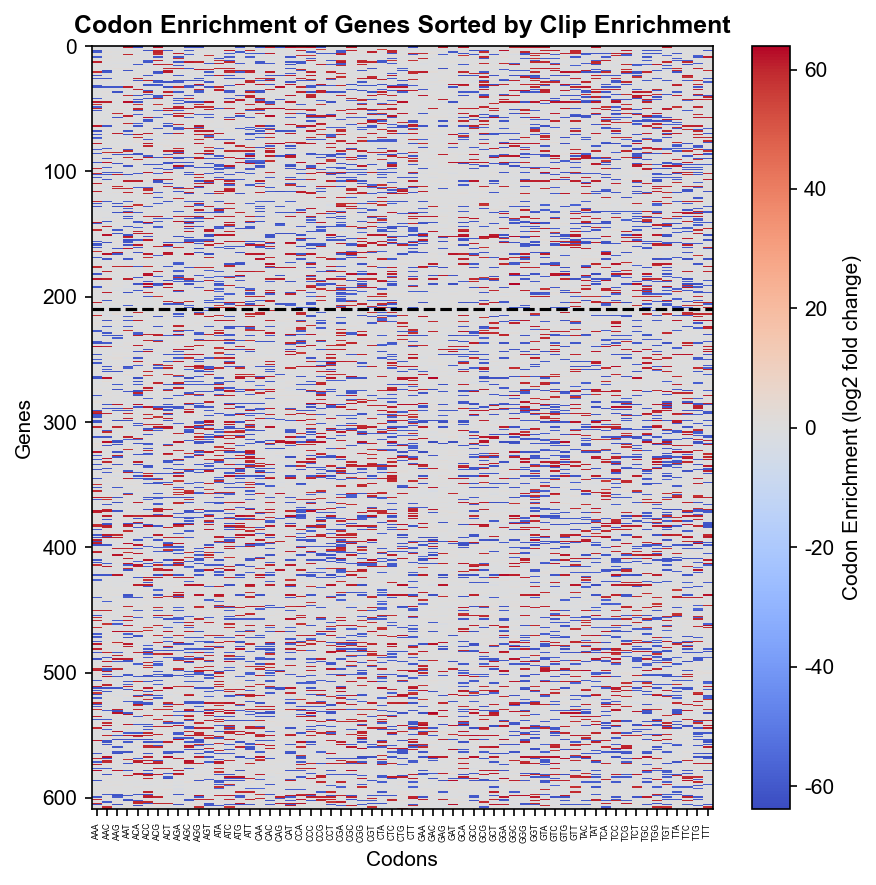

In [237]:
fig = plt.figure(figsize=(6, 6), dpi=150)
temp = filtered_codon_fc.sample(frac=0.1, random_state=42)  # Randomly sample 100 genes for visualization
plt.imshow(temp.iloc[:, :-2].values, cmap='coolwarm', aspect='auto', interpolation='nearest')
cnt = len(temp[temp['clip_enrichment'] > 0])
plt.colorbar(label='Codon Enrichment (log2 fold change)')
plt.axhline(y=cnt, color='black', linestyle='--', label='clip_enrichment > 0')
plt.xticks(ticks=np.arange(len(temp.columns[:-2])), labels=temp.columns[:-2], rotation=90, fontsize=4)
plt.xlabel('Codons')
plt.ylabel('Genes')
plt.title('Codon Enrichment of Genes Sorted by Clip Enrichment', fontweight='bold')
plt.tight_layout()
plt.show()

In [ ]:
# --------------------------------- #
# --- Codes generated by Gemini --- #
# --------------------------------- #

GTF_FILE = 'gencode-cds-with-genename.gtf'
FASTA_FILE = '../binfo1-datapack1/mm39.fa'

def reverse_complement(dna_seq):
    """DNA 서열의 reverse complement를 반환하는 함수"""
    complement_map = str.maketrans('ATCGN', 'TAGCN')
    return dna_seq.upper().translate(complement_map)[::-1]

In [143]:
def calculate_codon_frequencies(gtf_path, fasta_path):
    """
    GTF와 FASTA 파일로부터 유전자별 코돈 사용 빈도를 계산합니다.
    """
    print("GTF 파일 로딩 및 파싱 중...")
    try:
        gtf_df = pd.read_csv(
            gtf_path, sep='\t', comment='#', header=None,
            names=['chrom', 'source', 'feature', 'start', 'end', 'score', 'strand', 'frame', 'transcript_id', 'gene_id']
        )
    except Exception as e:
        print(f"오류: GTF 파일을 읽는 데 실패했습니다. 파일 형식(10컬럼)을 확인해주세요. 에러: {e}")
        return None

    # 전사체 정보를 딕셔너리로 구성
    transcripts_info = {}
    for transcript_id, group in gtf_df.groupby('transcript_id'):
        group = group.sort_values('start') # 유전체 좌표 기준 정렬
        transcripts_info[transcript_id] = {
            'gene_id': group['gene_id'].iloc[0],
            'chrom': group['chrom'].iloc[0],
            'strand': group['strand'].iloc[0],
            'cds_segments': list(zip(group['start'], group['end']))
        }
    print(f"총 {len(transcripts_info)}개의 전사체 정보 로드 완료.")

    # --- 유전자별 코돈 카운트 집계 ---
    # 한 유전자가 여러 전사체를 가질 수 있으므로, 유전자 ID를 기준으로 모든 카운트를 합산
    gene_codon_counts = defaultdict(Counter)
    genome = Fasta(fasta_path, sequence_always_upper=True)

    print("전사체별 CDS 서열 추출 및 코돈 카운트 집계 중...")
    wrong_cds_count = 0
    for t_info in tqdm(transcripts_info.values(), desc="Processing Transcripts"):
        cds_seq = ""
        # 1. CDS 구간들을 합쳐 전체 CDS 서열 생성
        for start, end in t_info['cds_segments']:
            # pyfaidx는 0-based, end-exclusive 이므로 GTF(1-based, inclusive) 좌표를 변환
            cds_seq += genome[t_info['chrom']][start - 1:end].seq

        # 2. 마이너스 스트랜드의 경우, 합쳐진 전체 서열에 대해 reverse complement 수행
        if t_info['strand'] == '-':
            cds_seq = reverse_complement(cds_seq)

        # 3. 품질 관리: CDS 길이가 3의 배수인지 확인
        if len(cds_seq) % 3 != 0 or not cds_seq.startswith('ATG'):
            print(f"Warning: invalid CDS length or does not start with ATG. Skipping.")
            wrong_cds_count += 1
            continue

        # 4. 코돈 단위로 잘라서 카운트
        codons = [cds_seq[i:i+3] for i in range(0, len(cds_seq), 3)]

        # 5. 유전자 ID를 기준으로 카운트 누적
        gene_id = t_info['gene_id']
        gene_codon_counts[gene_id].update(codons)

    genome.close()

    # --- 유전자별 코돈 빈도 계산 ---
    print(f"총 {len(gene_codon_counts)}개의 유전자에서 코돈 카운트 완료. 잘못된 CDS 건수: {wrong_cds_count}")
    print("유전자별 코돈 빈도 계산 중...")
    gene_codon_freqs = {}
    for gene_id, counts in tqdm(gene_codon_counts.items(), desc="Calculating Frequencies"):
        total_codons = sum(counts.values())
        if total_codons > 0:
            gene_codon_freqs[gene_id] = {codon: count / total_codons for codon, count in counts.items()}

    # 결과를 pandas DataFrame으로 변환
    freq_df = pd.DataFrame.from_dict(gene_codon_freqs, orient='index').fillna(0)

    # 모든 가능한 61개 코돈을 컬럼으로 설정 (누락된 코돈은 0으로 채움)
    all_codons = [a+b+c for a in 'TCAG' for b in 'TCAG' for c in 'TCAG' if a+b+c != 'TAA' and a+b+c != 'TAG' and a+b+c != 'TGA']
    for codon in all_codons:
        if codon not in freq_df.columns:
            freq_df[codon] = 0.0

    return freq_df[sorted(all_codons)] # 알파벳 순으로 정렬하여 반환

In [144]:
# 위에서 정의한 함수를 실행합니다.
codon_freq_df = calculate_codon_frequencies(GTF_FILE, FASTA_FILE)

# 결과 확인
if codon_freq_df is not None:
    print("\n--- 유전자별 코돈 빈도 계산 완료 ---")
    print("결과 DataFrame (상위 5개 유전자):")
    display(codon_freq_df.head())

GTF 파일 로딩 및 파싱 중...
총 30846개의 전사체 정보 로드 완료.
전사체별 CDS 서열 추출 및 코돈 카운트 집계 중...


Processing Transcripts:   0%|          | 0/30846 [00:00<?, ?it/s]

총 17340개의 유전자에서 코돈 카운트 완료. 잘못된 CDS 건수: 1308
유전자별 코돈 빈도 계산 중...


Calculating Frequencies:   0%|          | 0/17340 [00:00<?, ?it/s]


--- 유전자별 코돈 빈도 계산 완료 ---
결과 DataFrame (상위 5개 유전자):


,AAA,AAC,AAG,AAT,ACA,ACC,ACG,ACT,AGA,AGC,...,TCC,TCG,TCT,TGC,TGG,TGT,TTA,TTC,TTG,TTT
ENSMUSG00000000001.5,0.048023,0.022599,0.031073,0.016949,0.022599,0.019774,0.005650,0.016949,0.014124,0.016949,...,0.014124,0.000000,0.008475,0.008475,0.008475,0.019774,0.014124,0.011299,0.014124,0.036723
ENSMUSG00000000003.16,0.045977,0.028736,0.057471,0.028736,0.017241,0.011494,0.011494,0.005747,0.022989,0.011494,...,0.005747,0.000000,0.000000,0.011494,0.005747,0.011494,0.017241,0.017241,0.028736,0.022989
ENSMUSG00000020875.10,0.028497,0.012953,0.020725,0.012953,0.000000,0.010363,0.010363,0.002591,0.010363,0.041451,...,0.015544,0.023316,0.020725,0.010363,0.012953,0.002591,0.000000,0.020725,0.002591,0.010363
ENSMUSG00000000028.16,0.014733,0.019337,0.046041,0.011050,0.014733,0.017495,0.003683,0.015654,0.005525,0.020258,...,0.023020,0.009208,0.011050,0.009208,0.014733,0.009208,0.001842,0.020258,0.008287,0.033149
ENSMUSG00000048583.17,0.022222,0.011111,0.016667,0.000000,0.005556,0.016667,0.005556,0.005556,0.022222,0.027778,...,0.016667,0.016667,0.022222,0.033333,0.005556,0.011111,0.005556,0.044444,0.016667,0.005556


In [160]:
codon_freq_df.to_csv('gene_codon_frequencies.csv')
# ------------------------------------ #
# --- End of Gemini generated code --- #
# ------------------------------------ #

In [238]:
# Checkpoint 3
codon_freq_df = pd.read_csv('gene_codon_frequencies.csv', index_col=0)
eps = 1e-20
siluc_codon_cnt = siluc_codon_cnt.loc[siluc_codon_cnt.index.intersection(codon_freq_df.index)]
silin28a_codon_cnt = silin28a_codon_cnt.loc[silin28a_codon_cnt.index.intersection(codon_freq_df.index)]

In [239]:
len(siluc_codon_cnt), len(silin28a_codon_cnt), len(codon_freq_df)

(6808, 6465, 17340)

In [240]:
siluc_codon_cnt = siluc_codon_cnt.loc[siluc_codon_cnt.index.intersection(silin28a_codon_cnt.index)]
silin28a_codon_cnt = silin28a_codon_cnt.loc[silin28a_codon_cnt.index.intersection(siluc_codon_cnt.index)]
len(siluc_codon_cnt), len(silin28a_codon_cnt)

(6095, 6095)

In [241]:
siluc_codon_cnt = siluc_codon_cnt / (codon_freq_df.loc[siluc_codon_cnt.index].values + eps)
silin28a_codon_cnt = silin28a_codon_cnt / (codon_freq_df.loc[silin28a_codon_cnt.index].values + eps)

In [243]:
localization = pd.read_csv('../binfo1-datapack1/mouselocalization-20210507.txt', sep='\t')
localization.set_index('gene_id', inplace=True)
localization.head()

,Gene names,type
gene_id,,
ENSMUSG00000000001,Gnai3,cytoplasm
ENSMUSG00000000028,Cdc45 Cdc45l Cdc45l2,nucleus
ENSMUSG00000000049,Apoh B2gp1,cytoplasm
ENSMUSG00000000058,Cav2,cytoplasm
ENSMUSG00000000085,Scmh1,nucleus


In [244]:
siluc_codon_cnt.index = list(map(lambda x: x.split('.')[0], list(siluc_codon_cnt.index)))
silin28a_codon_cnt.index = list(map(lambda x: x.split('.')[0], list(silin28a_codon_cnt.index)))

In [245]:
IM = localization[localization['type'] == 'integral membrane'].index
IM_siluc = siluc_codon_cnt.loc[IM.intersection(siluc_codon_cnt.index)]
IM_siluc.head()

,CTT,AAC,GTC,GTT,GAT,GAC,ACA,GCC,TTC,GAG,...,TCG,GGT,CCC,CGT,TTG,AAT,ACG,CTA,GTA,ATA
ENSMUSG00000000120,0.0,0.432624,0.370821,0.648936,1.297872e-01,1.946809,3.522796e+00,5.970213e+00,0.000000e+00,0.839800,...,0.0,1.519757e+18,3.244681e-01,0.363404,0.259574,0.973404,5.191489,0.0,0.000000,0.0
ENSMUSG00000000171,0.0,0.000000,0.138986,11.118881,5.244755e+17,3.256244,0.000000e+00,5.244755e+17,0.000000e+00,0.000000,...,0.0,3.496503e+17,2.084790e-01,0.000000,0.092657,0.833916,0.000000,0.0,0.000000,0.0
ENSMUSG00000000194,0.0,0.652071,0.201832,0.000000,6.054945e+00,2.472436,7.064103e-01,2.354701e+00,3.532051e+00,2.590171,...,0.0,3.767521e+00,0.000000e+00,1.412821,0.941880,0.000000,1.883761,0.0,0.807326,0.0
ENSMUSG00000000326,0.0,2.387387,0.000000,0.000000,1.074324e+01,0.000000,1.432432e+01,2.702703e+18,2.702703e+18,0.000000,...,0.0,0.000000e+00,5.405405e+18,0.000000,1.790541,0.000000,7.162162,0.0,0.000000,0.0
ENSMUSG00000000420,0.0,0.000000,1.826797,1.644118,3.384948e+00,0.000000,2.941176e+18,0.000000e+00,1.450692e+00,3.288235,...,0.0,8.220588e+00,0.000000e+00,1.027574,1.494652,2.055147,0.000000,0.0,1.826797,0.0


In [246]:
nonIM_siluc = siluc_codon_cnt.loc[siluc_codon_cnt.index.difference(IM.intersection(siluc_codon_cnt.index))]
nonIM_siluc.head()

,CTT,AAC,GTC,GTT,GAT,GAC,ACA,GCC,TTC,GAG,...,TCG,GGT,CCC,CGT,TTG,AAT,ACG,CTA,GTA,ATA
ENSMUSG00000000001,0.118316,0.502841,0.365702,2.346591,5.028409,4.310065,5.028409e+00,1.005682,0.402273,1.005682,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0
ENSMUSG00000000028,0.000000,0.000000,1.063837,2.955102,4.432653,1.399785,6.648980e+00,1.564466,1.477551,3.626716,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0
ENSMUSG00000000056,0.000000,7.965517,0.000000,0.000000,14.793103,2.275862,1.724138e+18,0.000000,0.000000,5.689655,...,0.000000,0.000000,0.995690,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0
ENSMUSG00000000088,0.227718,0.260250,0.043375,2.819370,6.159239,0.390374,4.456328e+17,2.081996,0.390374,7.547237,...,0.065062,0.000000,3.383244,2.342246,1.040998,0.303624,0.000000,0.0,0.0,0.0
ENSMUSG00000000131,0.384313,1.825487,0.251791,0.331907,4.172542,1.168312,6.258813e+00,3.194602,1.043135,1.659534,...,0.384313,5.476461,0.521568,0.486797,0.663813,1.043135,0.730195,0.0,0.0,0.0


In [247]:
IM_silin28a = silin28a_codon_cnt.loc[IM.intersection(silin28a_codon_cnt.index)]
nonIM_silin28a = silin28a_codon_cnt.loc[silin28a_codon_cnt.index.difference(IM.intersection(silin28a_codon_cnt.index))]

In [ ]:
# --------------------------------- #
# --- Codes generated by Gemini --- #
# --------------------------------- #

# --- 2. 의사 카운트(Pseudocount) 계산 ---
# 모든 데이터프레임을 하나로 합쳐 0이 아닌 값들만 추출
all_values = np.concatenate([
    IM_siluc.values.flatten(), IM_silin28a.values.flatten(),
    nonIM_siluc.values.flatten(), nonIM_silin28a.values.flatten()
])
non_zero_values = all_values[all_values > 0]

# 0이 아닌 값들 중 1 퍼센타일 값을 의사 카운트로 사용
pseudo_count = np.percentile(non_zero_values, 1)
print(f"계산된 의사 카운트 (ψ): {pseudo_count:.2e}")


# --- 3. Enrichment 계산 함수 정의 ---
def calculate_enrichment(df_siluc, df_silin28a, pseudocount):
    enrichment_df = np.log2(
        (df_silin28a + pseudocount) / (df_siluc + pseudocount)
    )
    return enrichment_df

# --- 4. 각 그룹에 대해 Enrichment 계산 ---
IM_enrichment = calculate_enrichment(IM_siluc, IM_silin28a, pseudo_count)
non_IM_enrichment = calculate_enrichment(nonIM_siluc, nonIM_silin28a, pseudo_count)

# --- 5. 결과 비교 및 시각화 ---
# 각 코돈별 Enrichment의 중앙값(median)을 계산하여 그룹의 전반적인 경향 파악
median_IM_enrichment = IM_enrichment.median()
median_non_IM_enrichment = non_IM_enrichment.median()

# 비교를 위한 데이터프레임 생성
comparison_df = pd.DataFrame({
    'IM_enrichment': median_IM_enrichment,
    'non_IM_enrichment': median_non_IM_enrichment
}).reset_index().rename(columns={'index': 'codon'})

# ------------------------------------ #
# --- End of Gemini generated code --- #
# ------------------------------------ #

In [253]:
comparison_df

,codon,IM_enrichment,non_IM_enrichment,diff
0,AAA,0.000000,-0.554976,0.554976
1,AAC,0.019248,0.000000,0.019248
2,AAG,-1.391178,-1.192097,0.199082
3,AAT,-0.356821,-0.202098,0.154723
4,ACA,-1.488299,-2.192606,0.704307
...,...,...,...,...
56,TGT,0.000000,0.000000,0.000000
57,TTA,0.000000,0.000000,0.000000
58,TTC,0.000000,0.000000,0.000000
59,TTG,0.000000,0.000000,0.000000


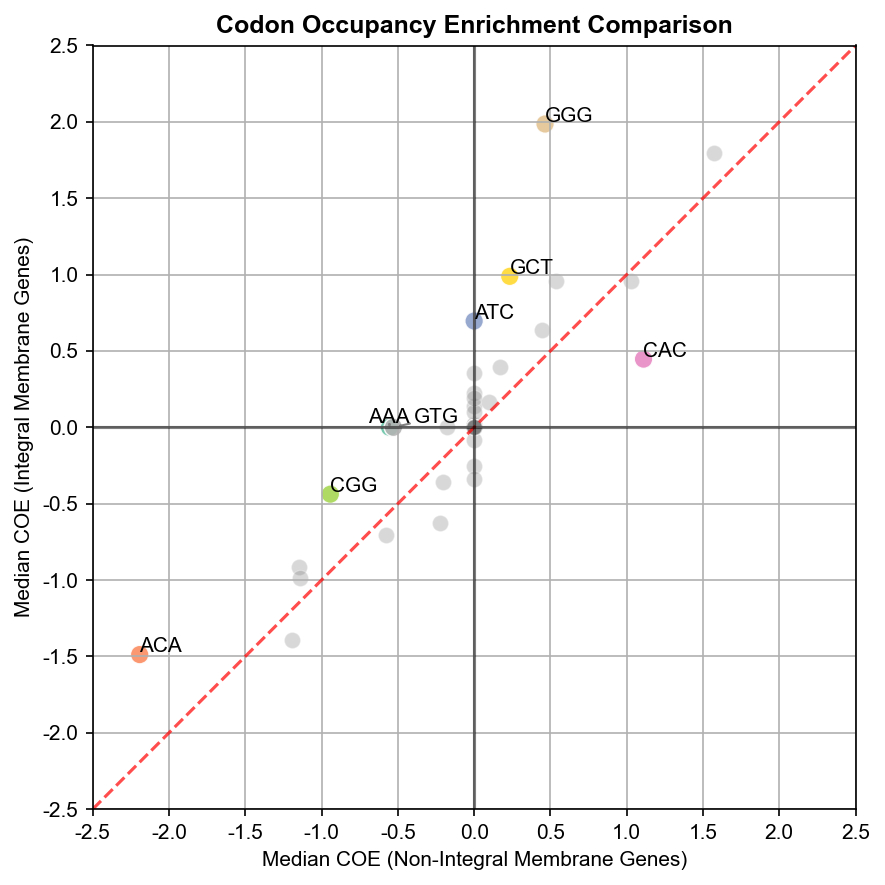

In [272]:
from adjustText import adjust_text

# Scatter plot으로 두 그룹의 경향성 비교
plt.figure(figsize=(6, 6), dpi=150)

comparison_df['diff'] = abs(comparison_df['IM_enrichment'] - comparison_df['non_IM_enrichment'])
threshold = 0.5 # 이 값은 데이터에 맞게 조절
significant_codons = comparison_df[
    (comparison_df['diff'] > threshold)
]
nonsignificant_codons = comparison_df[~comparison_df.index.isin(significant_codons.index)]

sns.scatterplot(data=significant_codons, x='non_IM_enrichment', y='IM_enrichment', hue='codon',
                   palette='Set2', s=80, alpha=0.9, legend=False)
sns.scatterplot(data=nonsignificant_codons, x='non_IM_enrichment', y='IM_enrichment', color='gray',
                   alpha=0.3, s=60, legend=False)

texts = []
for i, row in significant_codons.iterrows():
    texts.append(plt.text(row['non_IM_enrichment'], row['IM_enrichment'], row['codon']))
adjust_text(texts, arrowprops=dict(arrowstyle='->', color='gray'))

# y=x 대각선 추가 (두 그룹의 경향이 같은 지점)
# max_val = max(comparison_df['non_IM_enrichment'].max(), comparison_df['IM_enrichment'].max()) + 0.5
# min_val = min(comparison_df['non_IM_enrichment'].min(), comparison_df['IM_enrichment'].min()) - 0.5
min_val = -2.5
max_val = 2.5
plt.plot([min_val, max_val], [min_val, max_val], 'r--', alpha=0.7)

plt.title('Codon Occupancy Enrichment Comparison', fontweight='bold')
plt.xlabel('Median COE (Non-Integral Membrane Genes)')
plt.ylabel('Median COE (Integral Membrane Genes)')
plt.grid(True)
plt.axhline(0, color='k', linestyle='-', alpha=0.5)
plt.axvline(0, color='k', linestyle='-', alpha=0.5)
plt.xlim(min_val, max_val)
plt.ylim(min_val, max_val)
plt.xticks(np.arange(min_val, max_val + 0.5, 0.5))
plt.yticks(np.arange(min_val, max_val + 0.5, 0.5))
plt.tight_layout()
plt.show()

In [ ]:
from scipy import stats
from statsmodels.stats.multitest import fdrcorrection

results = []
# 데이터프레임의 각 컬럼(코돈)에 대해 반복
for codon in siluc_codon_cnt.columns:
    # 두 조건에서 해당 코돈의 점유율 데이터를 추출 (쌍체 데이터)
    x = siluc_codon_cnt[codon]
    y = silin28a_codon_cnt[codon]

    # 두 조건에서 모두 0인 경우는 의미가 없으므로 제외
    non_zero_mask = (x > 0) | (y > 0)
    x_filtered = x[non_zero_mask]
    y_filtered = y[non_zero_mask]

    # 데이터가 충분히 있을 때만 검정 수행 (예: 10개 이상)
    if len(x_filtered) < 10:
        continue

    # 윌콕슨 부호 순위 검정 실행
    # zero_method='pratt'는 0인 차이값을 처리하는 방법 중 하나입니다.
    try:
        stat, p_value = stats.wilcoxon(x_filtered, y_filtered, zero_method='pratt', alternative='two-sided')
        results.append({'codon': codon, 'p_value': p_value})
    except ValueError:
        # 모든 차이값이 0인 경우 등 예외 처리
        results.append({'codon': codon, 'p_value': 1.0})

# 결과를 DataFrame으로 변환
p_value_df = pd.DataFrame(results)

# --- 3. 다중 검정 보정 (Benjamini-Hochberg) ---

if not p_value_df.empty:
    # p-value가 NaN인 경우를 제외하고 보정 수행
    p_values_non_nan = p_value_df.dropna()['p_value']

    # FDR 보정 실행
    rejected, q_values = fdrcorrection(p_values_non_nan, alpha=0.05)

    # 원래 DataFrame에 q-value 컬럼 추가
    p_value_df['q_value'] = np.nan
    p_value_df.loc[p_values_non_nan.index, 'q_value'] = q_values

    # q-value 기준으로 결과 정렬
    final_results = p_value_df.sort_values('q_value').reset_index(drop=True)

    # --- 4. 최종 결과 출력 ---
    print("--- 최종 통계 검정 결과 (q-value가 낮은 순) ---")
    display(final_results)
else:
    print("유의미한 결과를 계산할 데이터가 충분하지 않습니다.")

--- 최종 통계 검정 결과 (q-value가 낮은 순) ---


,codon,p_value,q_value
0,ACA,0.000000,0.000000
1,AAG,0.000000,0.000000
2,GGC,0.000000,0.000000
3,CAC,0.000000,0.000000
4,CGG,0.000000,0.000000
...,...,...,...
56,CCG,0.456867,0.488928
57,GCA,0.485610,0.510727
58,CGT,0.629220,0.650549
59,TCG,0.692144,0.703679
